# Set up

## Set up Environment

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mp_image
from IPython import display    # Easily show images in notebook
import os
import cv2
import numpy as np
from skimage import io
from PIL import Image

## Set up Colab Environment

### First, mount google drive to the notebook. This must be done every time the notebook is re-run. 

In [ ]:
from google.colab import drive # Connect colab to google drive

In [ ]:
drive.mount('/drive') 
%cd /drive/MyDrive/W210 - Capstone/

Mounted at /drive
/drive/MyDrive/W210 - Capstone


# Data Load

## Now, we can start loading our data

We have data from x different sources: let's start with data from the ISIC 2018 challenge. We know the dat has the following characteristics: 
1. Train is comprised of 10k images of zoomed in skin markings. 
2. Each train observation also has metadata:
    
    a. lesion id, image id
    
    b. dx: diagnosis (type of cancer, or benign)
    
    c. dx_type: the way the diagnosis was inferrred
    
    d. age
    
    e. sex
    
    f. localization: the location of the marking on the person
    
    g. dataset: unknown

3. Test has x images with no metadata
4. Val has x images with no metadata


In [ ]:
train_path = './Data/ISIC_2018/Train/'
val_path = './Data/ISIC_2018/ISIC2018_Task3_Val_Input/'
test_path = './Data/ISIC_2018/ISIC2018_Task3_Test_Input/'

### First, Studying in the metadata

In [ ]:
df = pd.read_csv(train_path + 'HAM10000_metadata.csv')

#### Histograms
Looking at distributions, we can see that we have some serious class imbalance, and some interesting trends across other predictors

In [ ]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


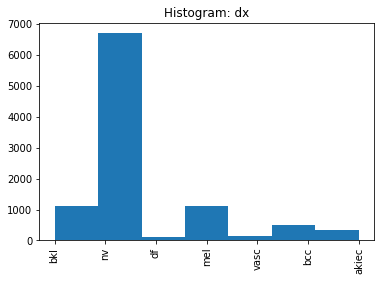

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


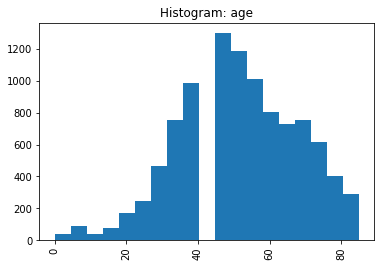

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
10.0      41
0.0       39
Name: age, dtype: int64


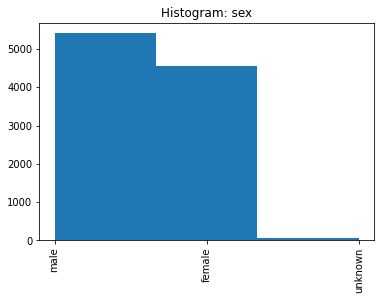

male       5406
female     4552
unknown      57
Name: sex, dtype: int64


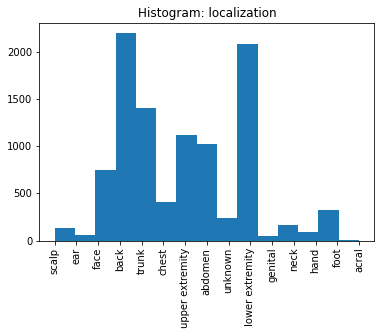

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64


In [ ]:
cols = df.columns[[2, 4, 5, 6]]    # Columns of interest

for col in cols:
    plt.hist(df[col], bins = len(df[col].unique()))
    plt.xticks(rotation = 'vertical')
    plt.title('Histogram: ' + col)
    plt.show()
    print(df[col].value_counts())

### Images
Now, we can sample a few random images and see what they look like. The format of these data are .jpg. We can start by randomly sampling 10 images from the metadata dataframe. The images are tagged with their 'image_id', which looks like ISIC_#######.jpg. Let's look at 5 randomly sampled images from each dx

In [ ]:
dx_type = pd.Series()
image_ids = pd.Series()

for diagnosis in df['dx'].unique():
    dx_type = dx_type.append(pd.Series(diagnosis).repeat(5))
    image_ids = image_ids.append(df[df['dx'] == diagnosis]['image_id'].sample(5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
image_ids.reset_index(inplace = True, drop = True)
dx_type.reset_index(inplace = True, drop = True)
samples = pd.concat([image_ids, dx_type], axis = 1)
samples = samples.rename(columns = {0: "image_id", 1: "diagnosis"})


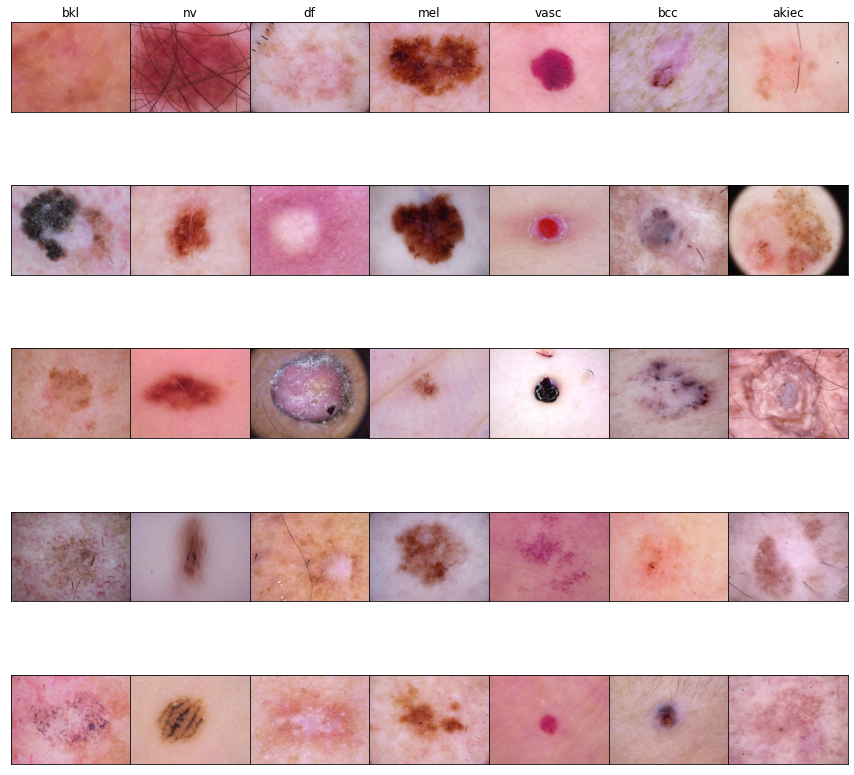

In [ ]:
n_samples = 5
diagnoses = 7
img_count = 0

fig, axes = plt.subplots(nrows = n_samples, ncols = diagnoses, figsize = (15, 15))

for j in range(diagnoses):
    for i in range(n_samples):
        if img_count < len(samples):
            image = mp_image.imread(train_path + 'HAM10000_images_part_1_and_2/' + samples.image_id[img_count]+'.jpg')
            
            if i == 0:
                axes[i, j].set_title(samples.diagnosis[img_count])
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].imshow(image)
            img_count += 1
plt.subplots_adjust(wspace = 0, hspace = 0)

### EDA on Images

Next, it would be interesting to know the average color of images, and see if we can identify the average localization of the blemishes

First, some summary statistics

In [ ]:
# %pip install basic_image_eda

In [ ]:
# credits: https://github.com/Soongja/basic-image-eda
from basic_image_eda import BasicImageEDA

if __name__ == "__main__":  # for multiprocessing
    data_dir = train_path + 'HAM10000_images_part_1_and_2/'
    # BasicImageEDA.explore(data_dir)
        
    # or
    
    extensions = ['png', 'jpg', 'jpeg']
    threads = 0
    dimension_plot = True
    channel_hist = True
    nonzero = False
    hw_division_factor = 1.0
    
    BasicImageEDA.explore(data_dir, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

ModuleNotFoundError: ignored

In [ ]:
display.Image(train_path + 'HAM10000_images_part_1_and_2/ISIC_0030522.jpg')

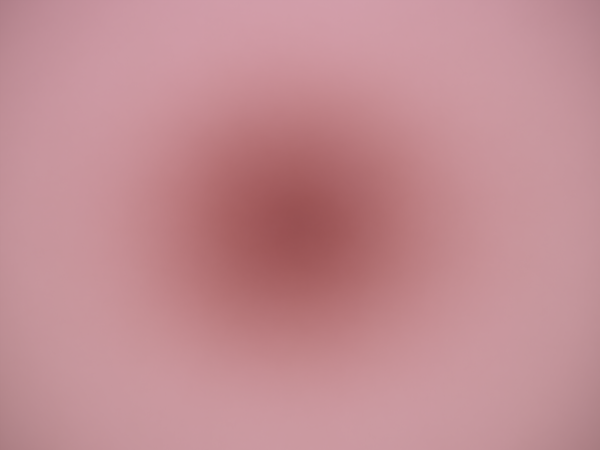

In [ ]:
# load images into array
# Credit: https://pythonmatplotlibtips.blogspot.com/2018/01/generate-average-image-using-python-and-PIL.html
sample_images = df.image_id.sample(
    
)
ims = []

for i in sample_images:
    ims.append(Image.open(train_path + 'HAM10000_images_part_1_and_2/' + i + '.jpg', mode = 'r'))


# Convert to np array
ims = np.array([np.array(im) for im in ims])

# Calculate average
imave = np.average(ims, axis = 0)

# Display the image
Image.fromarray(imave.astype('uint8'))

In [ ]:

imave.shape

(450, 600, 3)

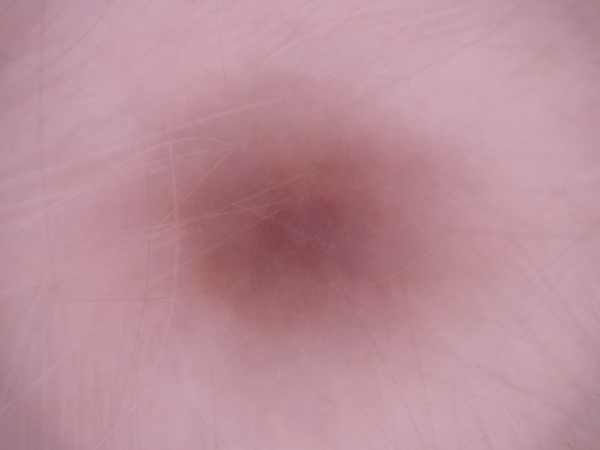

In [ ]:
Image.fromarray(imave.astype('uint8'))